In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anupa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anupa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

100%|██████████| 41.0M/41.0M [00:04<00:00, 10.2MB/s]

Extracting files...


In [11]:
print(path)

C:\Users\anupa\.cache\kagglehub\datasets\emineyetm\fake-news-detection-datasets\versions\1


In [ ]:
fake_df = pd.read_csv(path+'/News _dataset/Fake.csv')
true_df = pd.read_csv(path+'/News _dataset/True.csv')

# Add labels: 1 for Fake, 0 for True
fake_df['label'] = 1
true_df['label'] = 0


combined_df = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

In [16]:
required_cols = ['text', 'title', 'subject']

if 'text' not in combined_df.columns and 'content' in combined_df.columns:
    combined_df.rename(columns={'content': 'text'}, inplace=True)


if 'text' not in combined_df.columns:

    if 'title' in combined_df.columns:
        combined_df['text'] = combined_df['title']
    else:
        raise ValueError("Neither 'text' nor 'title' columns found in dataset")


combined_df = combined_df.dropna(subset=['text'])


df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Fill nulls and combine title and text
df['text'] = df['text'].fillna('')
df['title'] = df['title'].fillna('')
df['content'] = df['title'] + ' ' + df['text']
df['cleaned_text'] = df['content'].apply(clean_text)

Now Feature Extraction

In [18]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4284
           1       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



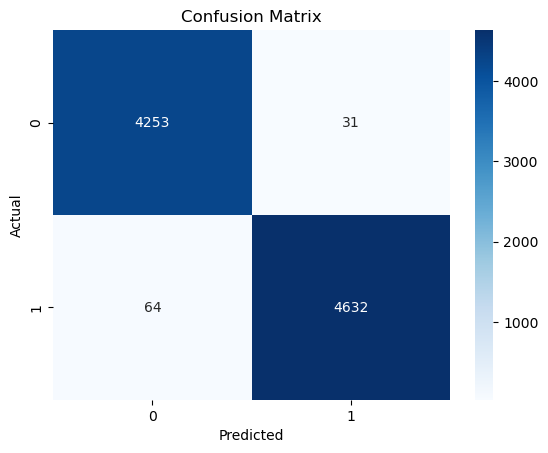

In [21]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

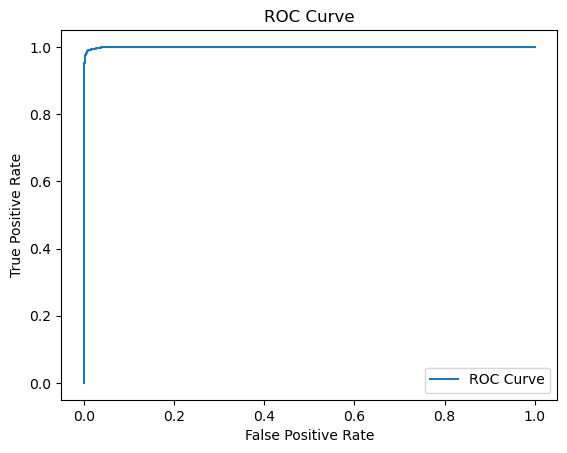

ROC-AUC Score: 0.999460573553669


In [22]:
probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("ROC-AUC Score:", roc_auc_score(y_test, probs))

In [25]:
from sklearn.pipeline import Pipeline
import joblib

# 1. Build a pipeline that wraps both steps
pipe = Pipeline([
    ('tfidf', tfidf),       # your already-fitted TfidfVectorizer
    ('clf', model)          # your trained LogisticRegression
])

# 2. Save the entire pipeline
joblib.dump(pipe, 'news_classifier_pipeline.pkl')


['news_classifier_pipeline.pkl']

In [26]:
df.head()

,title,text,subject,date,label,content,cleaned_text
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1,Ben Stein Calls Out 9th Circuit Court: Committ...,ben stein call th circuit court committed ‘cou...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0,Trump drops Steve Bannon from National Securit...,trump drop steve bannon national security coun...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0,Puerto Rico expects U.S. to lift Jones Act shi...,puerto rico expects u lift jones act shipping ...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1,OOPS: Trump Just Accidentally Confirmed He Le...,oops trump accidentally confirmed leaked israe...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0,Donald Trump heads for Scotland to reopen a go...,donald trump head scotland reopen golf resort ...


In [27]:
import joblib
import pandas as pd
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# 1. Load the trained pipeline
pipe = joblib.load('news_classifier_pipeline.pkl')  # or your separate pkl(s)

# 2. Re‐define your cleaning fn so it matches training
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = [
        lemmatizer.lemmatize(w)
        for w in text.split()
        if w not in stop_words
    ]
    return ' '.join(tokens)

# 3. Build a DataFrame for your single test row
row = {
    'title':  " Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",
    'text':   "Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",
    'subject':"News",
    'date':   "December 31, 2017",
    
}
df_test = pd.DataFrame([row])
df_test['content'] = df_test['title'].fillna('') + ' ' + df_test['text'].fillna('')
df_test['cleaned_text'] = df_test['content'].apply(clean_text)

# 4. Predict
X_new = df_test['cleaned_text'].tolist()
pred_labels = pipe.predict(X_new)
pred_probs  = pipe.predict_proba(X_new)[:, 1]  # probability of “REAL”

for i, (lbl, prob) in enumerate(zip(pred_labels, pred_probs)):
    print(f"Sample {i}: predicted = {lbl}, confidence = {prob:.3f}")


Sample 0: predicted = 1, confidence = 0.987
